## This notebook contains the installation steps for the necessary libraries for Project 1. Use this to start working for Project 1. You can create a copy of this notebook for each milestone.

In [1]:
!nvidia-smi

Sat Apr  5 23:54:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             50W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
!pip install -q datasets transformers evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install phantominator
from phantominator import shepp_logan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.4 MB/s eta 0:00:00


In [5]:
!pip install --upgrade huggingface_hub

In [6]:
from huggingface_hub import login

In [7]:
# !pip install phantomator
!pip install phantominator
from phantominator import shepp_logan  # correct


In [8]:
!pip install numpy pandas matplotlib seaborn opencv-python torch torchvision transformers datasets evaluate huggingface_hub tensorflow scipy
# glob does not need to be installed?

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
# MRI Image Classification Pipeline in Google Colab
# Libraries Installation

# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import random
from PIL import Image
# from phantomator import shepp_logan
from phantominator import shepp_logan  # correct
from scipy.fftpack import fft2, ifft2, fftshift
import torch
import torchvision.transforms as transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Set up the environment to use GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Data loading paths
train_tumor = glob.glob('/content/drive/MyDrive/mri_data_full/mri_data_full/train/tumor/*.jpg')
train_no_tumor = glob.glob('/content/drive/MyDrive/mri_data_full/mri_data_full/train/notumor/*.jpg')
test_tumor = glob.glob('/content/drive/MyDrive/mri_data_full/mri_data_full/test/tumor/*.jpg')
test_no_tumor = glob.glob('/content/drive/MyDrive/mri_data_full/mri_data_full/test/notumor/*.jpg')


In [ ]:

# Visualize MRI Images
fig, axes = plt.subplots(2, 10, figsize=(20, 5))
for i in range(10):
    img_tumor = cv2.imread(random.choice(train_tumor), cv2.IMREAD_GRAYSCALE)
    axes[0, i].imshow(img_tumor, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Tumor')

    img_no_tumor = cv2.imread(random.choice(train_no_tumor), cv2.IMREAD_GRAYSCALE)
    axes[1, i].imshow(img_no_tumor, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('No Tumor')

plt.show()

In [ ]:
# Histogram Equalization Example
def histogram_equalization(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    equalized_img = cv2.equalizeHist(img)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(equalized_img, cmap='gray')
    axes[1].set_title('Equalized')
    axes[1].axis('off')

    plt.show()

histogram_equalization(random.choice(train_tumor))


In [ ]:
# MRI Phantom Reconstruction
phantom = shepp_logan(256)
frequency_space = fftshift(fft2(phantom))
reconstructed_image = np.abs(ifft2(frequency_space))

plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(phantom, cmap='gray'), plt.title('Original Phantom')
plt.subplot(132), plt.imshow(np.log(1 + np.abs(frequency_space)), cmap='gray'), plt.title('Frequency Space')
plt.subplot(133), plt.imshow(reconstructed_image, cmap='gray'), plt.title('Reconstructed Image')
plt.show()

# Load and preprocess data for ViT model
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')


In [ ]:
def preprocess_images(image_paths, label):
    images = [Image.open(path).convert('RGB') for path in image_paths]
    encoding = feature_extractor(images, return_tensors='pt')
    return encoding['pixel_values'], torch.tensor([label]*len(images))

In [ ]:
train_images, train_labels = preprocess_images(train_tumor + train_no_tumor, 1)  # 1 for tumor, modify accordingly
test_images, test_labels = preprocess_images(test_tumor + test_no_tumor, 1)  # similarly modify

# Initialize ViT model
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k', num_labels=2).to(device)

# Training setup
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
epochs = 3

# Training Loop
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(pixel_values=train_images.to(device), labels=train_labels.to(device))
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Inference and Confusion Matrix
model.eval()
with torch.no_grad():
    outputs = model(pixel_values=test_images.to(device))
    predictions = torch.argmax(outputs.logits, axis=1).cpu().numpy()

Using device: cpu


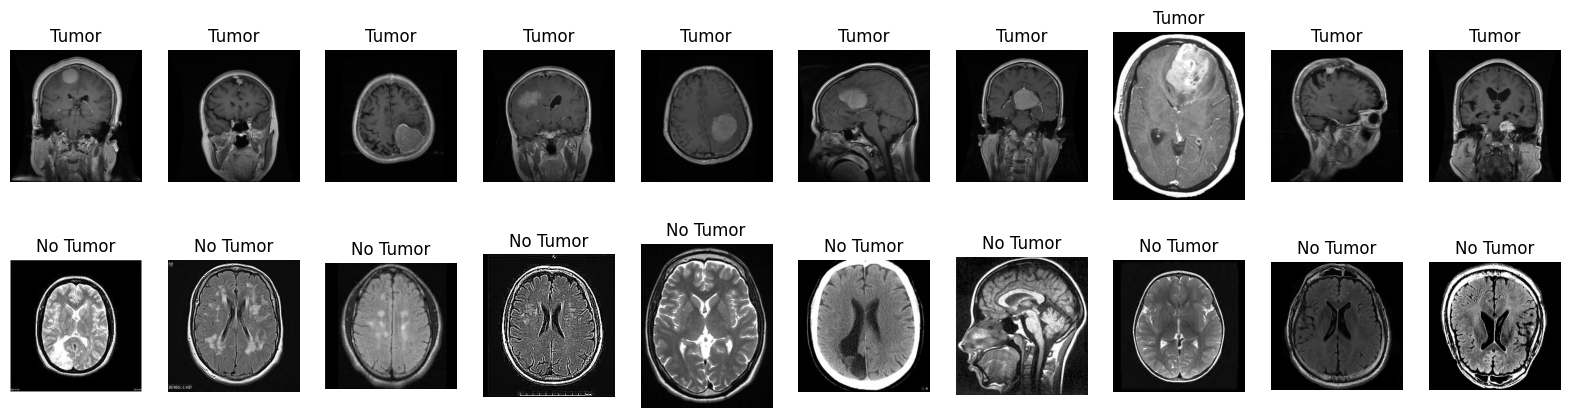

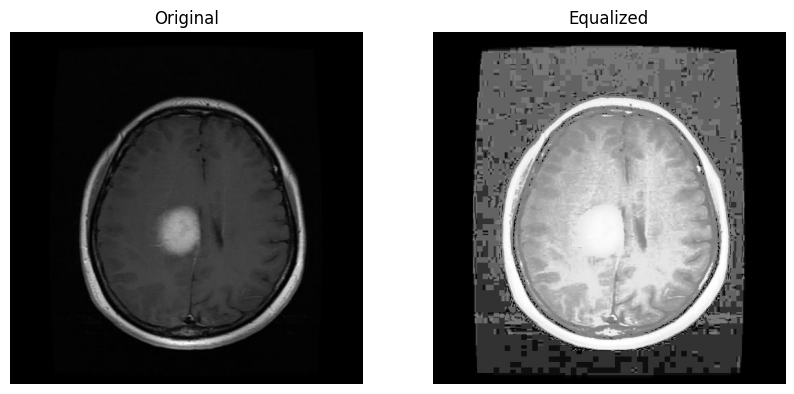

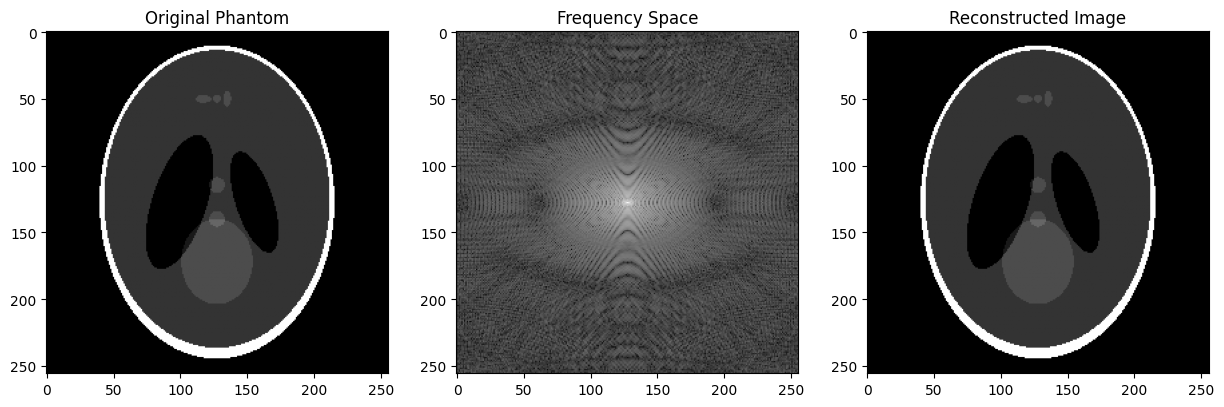

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
cm = confusion_matrix(test_labels.numpy(), predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Tumor', 'Tumor'])
disp.plot(cmap='Blues')
plt.show()
